# Implementation of Association Algorithms

### Importing all the Necessary packages


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder


### Importing and oberserving the dataset


In [16]:
df = pd.read_csv("netflix_titles.csv")
df.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


### Inspecting the dataset


In [17]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


## I'd like to use the Apriori Algorithm to evaluate country involvement in the production process (for example, which countries the US produces more movies/TV shows with) and will generate a new data frame to do so. It can be made easier with one-hot encoding.


In [18]:
# subsetting , cleaning and splitting the dataset
country = (
    df.loc[df.country.notnull(), "country"].astype("str").apply(lambda t: t.split(", "))
)

# Convert DataFrame column into list of strings
country = list(country)

# number of movies/TV shows without null values
len(country)


7280

In [19]:
# Instantiating the encoder and identifying the unique countries
encoder = TransactionEncoder().fit(country)

# One-hot encoding
onehot_country = encoder.transform(country)

# Convert one-hot encoded data to DataFrame and set show_id as index
onehot_country = pd.DataFrame(
    onehot_country,
    columns=encoder.columns_,
    index=df.loc[df.country.notnull(), "show_id"],
)

# Print the one-hot encoded country dataset
onehot_country.head()


,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,...,United Kingdom,"United Kingdom,",United States,"United States,",Uruguay,Vatican City,Venezuela,Vietnam,West Germany,Zimbabwe
show_id,,,,,,,,,,,,,,,,,,,,,
s1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
s2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
s3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
s4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
s5,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


### It is not difficult to interpret this table. In Brazil, for example, a film/TV show with the show id "s1" was created. As a result, the Brazil column for this row is True. The remaining columns are all False. We can measure each country's share of movie/TV show output in the Netflix dataset using this new table.


In [20]:
# Print the one-hot encoded country share dataset
country_share = onehot_country.mean().sort_values(ascending=False).round(4) * 100
country_share


United States     45.27
India             13.60
United Kingdom     9.92
Canada             5.66
France             4.79
                  ...  
Kazakhstan         0.01
Jamaica            0.01
Slovakia           0.01
Somalia            0.01
Afghanistan        0.01
Length: 121, dtype: float64

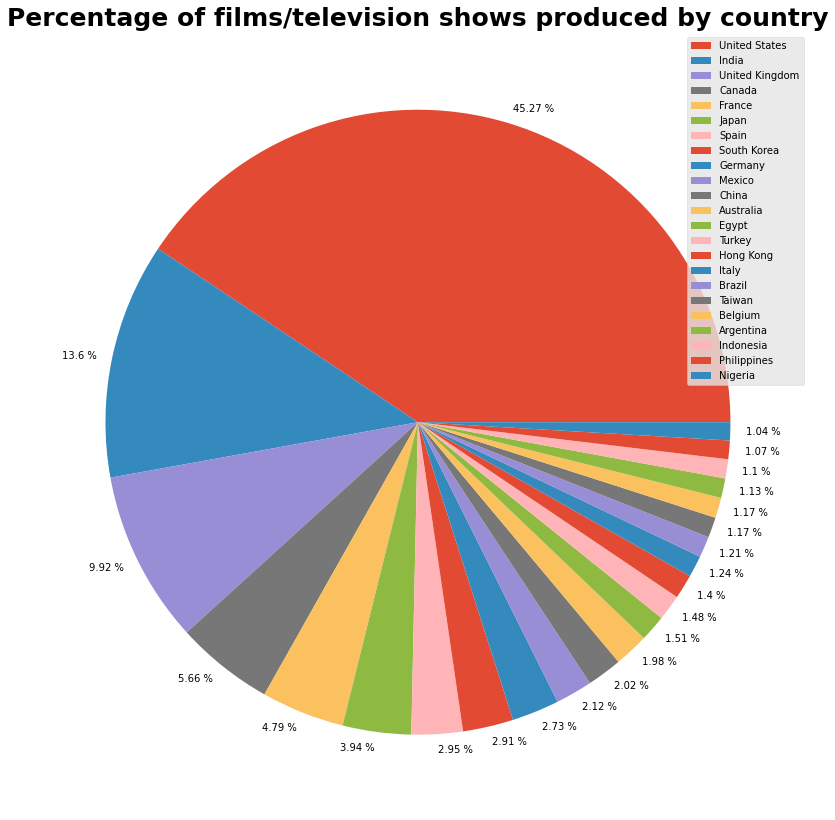

In [21]:
# Plotting the countries that share more than 1%
country_share = country_share[country_share > 1]
labels = country_share.round(3).astype("str") + " %"
fig1, ax1 = plt.subplots(figsize=(14, 40), facecolor="white")
ax1.pie(
    country_share,
    labels=labels,
    labeldistance=1.05,
    shadow=False,
)
plt.title(
    "Percentage of films/television shows produced by country",
    fontsize=25,
    fontweight="bold",
)
plt.legend(labels=country_share.index, loc="upper right")
plt.show()


### According to the pie chart above, the United States produced 45.2 percent of films and television shows, with the rest produced in cooperation with other nations. Now I'm curious as to which country collaborates the most with the United States in the production of films and television shows.


In [22]:
# Compute frequency using the Apriori algorithm
frequency = apriori(
    onehot_country[onehot_country["United States"] == True],
    min_support=0.0001,
    max_len=4,
    use_colnames=True,
).rename({"support": "frequency", "itemsets": "Countries"}, axis=1)

# sort row which contain 'United States' and more than 1 country
frequency = (
    frequency[
        (frequency.Countries.apply(lambda t: "United States" in t))
        & (frequency.Countries.apply(lambda t: len(t) >= 2))
    ]
    .sort_values("frequency", ascending=False)
    .round(3)
)

# Print a preview of the frequency
frequency.head()


,frequency,Countries
531,0.070,"(United Kingdom, United States)"
207,0.057,"(Canada, United States)"
301,0.030,"(France, United States)"
324,0.022,"(Germany, United States)"
400,0.015,"(Japan, United States)"


## To clean and analyse the genre variable, we can use the same one-hot encode methodology.


In [23]:
# subset dataset and split
genre = df["listed_in"].apply(lambda t: t.split(", "))

# Convert DataFrame column into list of strings
genre = list(genre)

# number of movies/TV Shows
len(genre)


7787

In [24]:
# Instantiate transaction encoder and identify unique items
encoder = TransactionEncoder().fit(genre)

# One-hot encode transactions
onehot = encoder.transform(genre)

# Convert one-hot encoded data to DataFrame and set show_id as index
onehot_genre = pd.DataFrame(onehot, columns=encoder.columns_, index=df["show_id"])

# Print the one-hot encoded transaction dataset
onehot_genre.shape


(7787, 42)

## In the 7787 Movies/TV Shows dataset, there are 42 different genres. We can compute and visualise the number of movies and television shows in each genre.


In [25]:
genre_count = onehot_genre.sum().sort_values(ascending=False)
genre_count.head()


International Movies      2437
Dramas                    2106
Comedies                  1471
International TV Shows    1199
Documentaries              786
dtype: int64

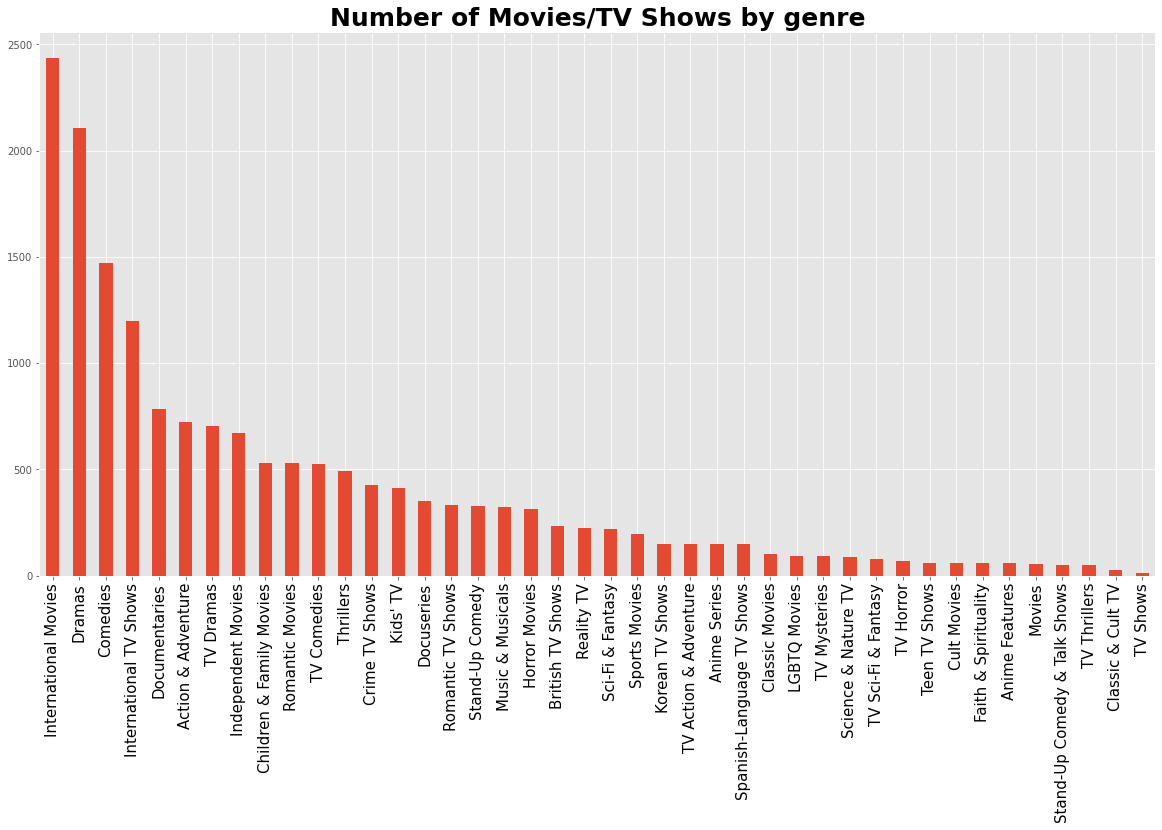

In [26]:
plt.style.use("ggplot")
plt.figure(figsize=(20, 10))
genre_count.plot(kind="bar")
plt.xticks(rotation="90")
plt.tick_params(axis="x", labelsize=15, labelcolor="black")
plt.title(
    "Number of Movies/TV Shows by genre",
    fontsize=25,
    fontweight="bold",
)
plt.show()


## The most popular genre appears to be "International Movies," yet this makes no sense to me in terms of the genre. As a result, let's have a look at the most popular genre pairing with "International Movies."


In [27]:
# Compute frequent itemsets using the Apriori algorithm
frequency = apriori(
    onehot_genre[onehot_genre["International Movies"] == True],
    min_support=0.0001,
    max_len=2,
    use_colnames=True,
).rename({"support": "frequency", "itemsets": "Genre"}, axis=1)

# sort row which contain 'International Movies' and more than 1 genre
frequency = (
    frequency[
        (frequency.Genre.apply(lambda t: "International Movies" in t))
        & (frequency.Genre.apply(lambda t: len(t) >= 2))
    ]
    .sort_values("frequency", ascending=False)
    .round(3)
)

frequency.head()


,frequency,Genre
65,0.531,"(Dramas, International Movies)"
48,0.300,"(Comedies, International Movies)"
26,0.145,"(Action & Adventure, International Movies)"
82,0.135,"(Romantic Movies, International Movies)"
59,0.108,"(Documentaries, International Movies)"


## According to the data above, dramas account for 53% of all international films (2437). Comedies account for 30% of the films, while action and adventure films account for 15%.


In [28]:
# Compute frequent itemsets using the Apriori algorithm
frequency = apriori(
    onehot_genre[onehot_genre["International TV Shows"] == True],
    min_support=0.0001,
    max_len=2,
    use_colnames=True,
).rename({"support": "frequency", "itemsets": "Genre"}, axis=1)

# sort row which contain 'International TV Shows' and more than 1 genre
frequency = (
    frequency[
        (frequency.Genre.apply(lambda t: "International TV Shows" in t))
        & (frequency.Genre.apply(lambda t: len(t) >= 2))
    ]
    .sort_values("frequency", ascending=False)
    .round(3)
)

frequency.head()


,frequency,Genre
62,0.391,"(TV Dramas, International TV Shows)"
56,0.238,"(Romantic TV Shows, International TV Shows)"
40,0.224,"(Crime TV Shows, International TV Shows)"
61,0.170,"(TV Comedies, International TV Shows)"
58,0.108,"(Spanish-Language TV Shows, International TV S..."


## Drama is also the most popular genre of international television shows (40 percent ). Nonetheless, romantic and crime dramas are ranked second and third, respectively, in the TV Shows category (people choose to watch detective and love dramas on TV).
